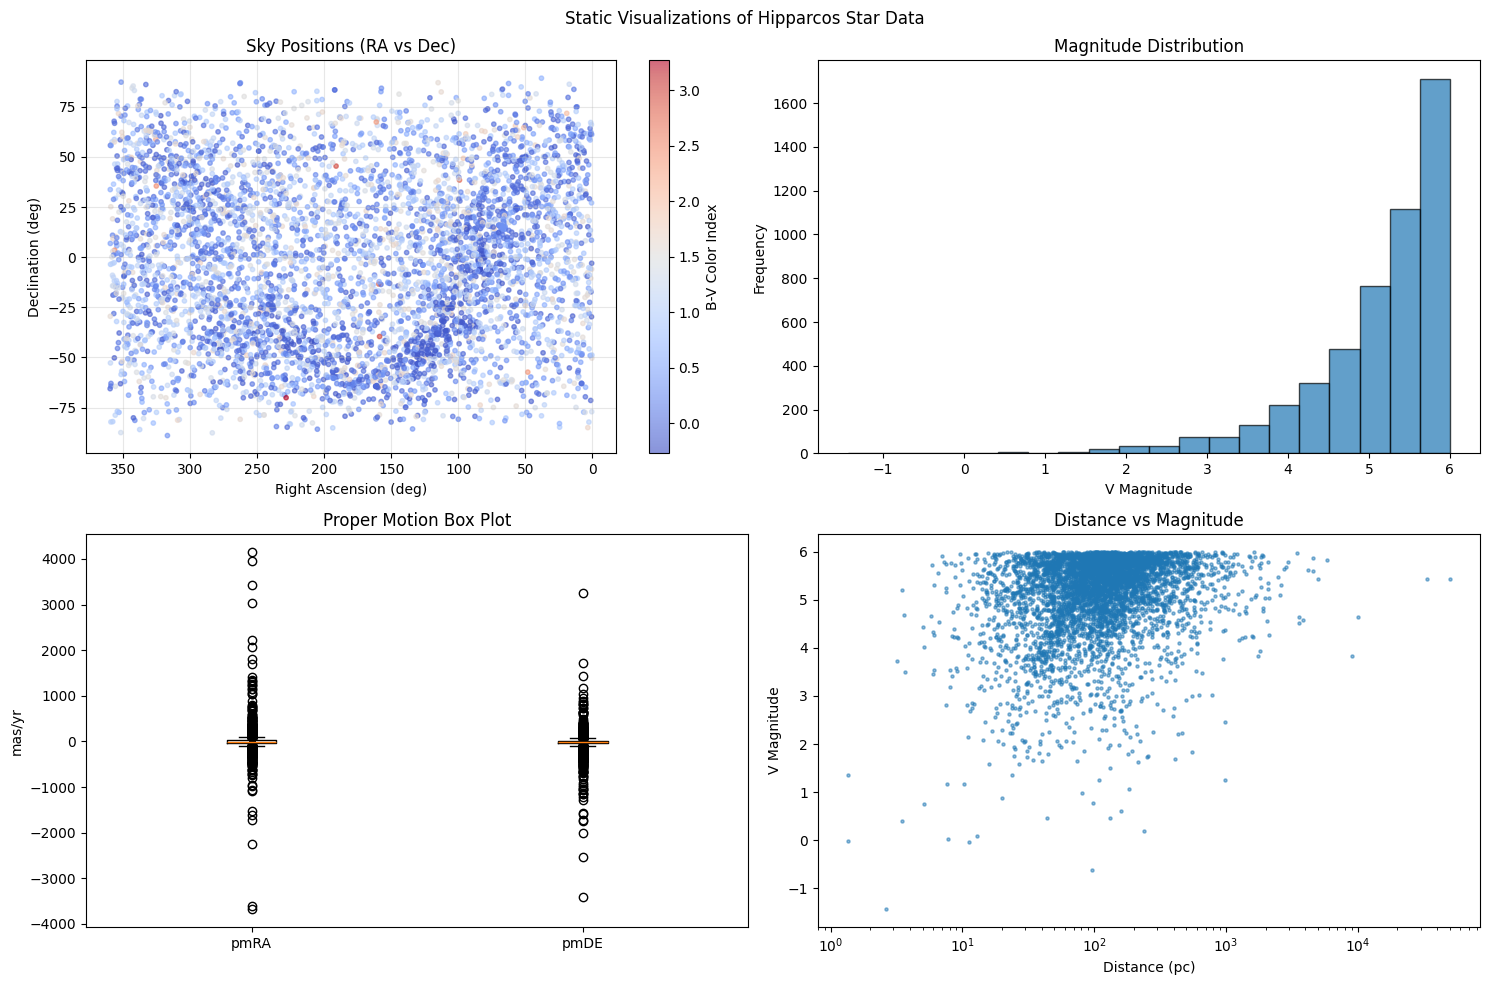

Static visualizations saved as 'hipparcos_static_viz.svg'.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import numpy as np
import os  # For file handling, similar to notebook

# --- CSV Data Handling (Demonstrating data loading, cleaning, and processing from notebook) ---
# Load the CSV data (similar to processing tides_processed.csv in the notebook)
try:
    df = pd.read_csv('hipparcos-voidmain.csv')
except FileNotFoundError:
    print("Error: 'hipparcos-voidmain.csv' not found. Ensure the file is in the correct directory.")
    exit(1)

# Clean the data: drop rows with missing essential values (data processing step)
df = df.dropna(subset=['RAdeg', 'DEdeg', 'Vmag', 'pmRA', 'pmDE', 'B-V'])

# Additional processing: Compute distance estimate from parallax if available (Plx > 0)
df['Distance_pc'] = np.where(df['Plx'] > 0, 1000 / df['Plx'], np.nan)  # Parsecs

# Limit to brightest 5000 stars for performance
df = df.sort_values('Vmag').head(5000)

# --- Data Visualization with Matplotlib (Multiple subplots like in notebook's tide visualizations) ---
# Create subplot with multiple static visualizations before animation
if len(df) > 10:
    fig_static, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig_static.suptitle('Static Visualizations of Hipparcos Star Data', color='black')

    # Scatter plot: RA vs Dec, colored by B-V (stellar color/temperature)
    scatter = axes[0, 0].scatter(df['RAdeg'], df['DEdeg'], c=df['B-V'], cmap='coolwarm', alpha=0.6, s=10)
    axes[0, 0].set_title('Sky Positions (RA vs Dec)')
    axes[0, 0].set_xlabel('Right Ascension (deg)')
    axes[0, 0].set_ylabel('Declination (deg)')
    axes[0, 0].invert_xaxis()  # Typical sky map orientation
    axes[0, 0].grid(True, alpha=0.3)
    fig_static.colorbar(scatter, ax=axes[0, 0], label='B-V Color Index')

    # Histogram: Distribution of Visual Magnitudes (Vmag)
    axes[0, 1].hist(df['Vmag'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Magnitude Distribution')
    axes[0, 1].set_xlabel('V Magnitude')
    axes[0, 1].set_ylabel('Frequency')

    # Box plot: Proper Motions (pmRA and pmDE)
    axes[1, 0].boxplot([df['pmRA'].dropna(), df['pmDE'].dropna()], labels=['pmRA', 'pmDE'])
    axes[1, 0].set_title('Proper Motion Box Plot')
    axes[1, 0].set_ylabel('mas/yr')

    # Scatter: Distance vs Magnitude (for stars with valid parallax)
    df_dist = df.dropna(subset=['Distance_pc'])
    axes[1, 1].scatter(df_dist['Distance_pc'], df_dist['Vmag'], alpha=0.5, s=5)
    axes[1, 1].set_title('Distance vs Magnitude')
    axes[1, 1].set_xlabel('Distance (pc)')
    axes[1, 1].set_ylabel('V Magnitude')
    axes[1, 1].set_xscale('log')  # Log scale for distance

    plt.tight_layout()
    plt.show()

    # Save one visualization as SVG (demonstrating programmatic graphics creation like in notebook)
    fig_static.savefig('hipparcos_static_viz.svg', format='svg')
    print("Static visualizations saved as 'hipparcos_static_viz.svg'.")
else:
    print("Not enough data for static visualizations.")

MovieWriter ffmpeg unavailable; using Pillow instead.


FFmpeg not found. Saving as GIF instead.
Animation saved as 'stellar_evolution_animation.gif'.
Files created: ['hipparcos_static_viz.svg', 'stellar_evolution_animation.gif']
Animation saved as 'stellar_evolution_animation.gif'.
Files created: ['hipparcos_static_viz.svg', 'stellar_evolution_animation.gif']


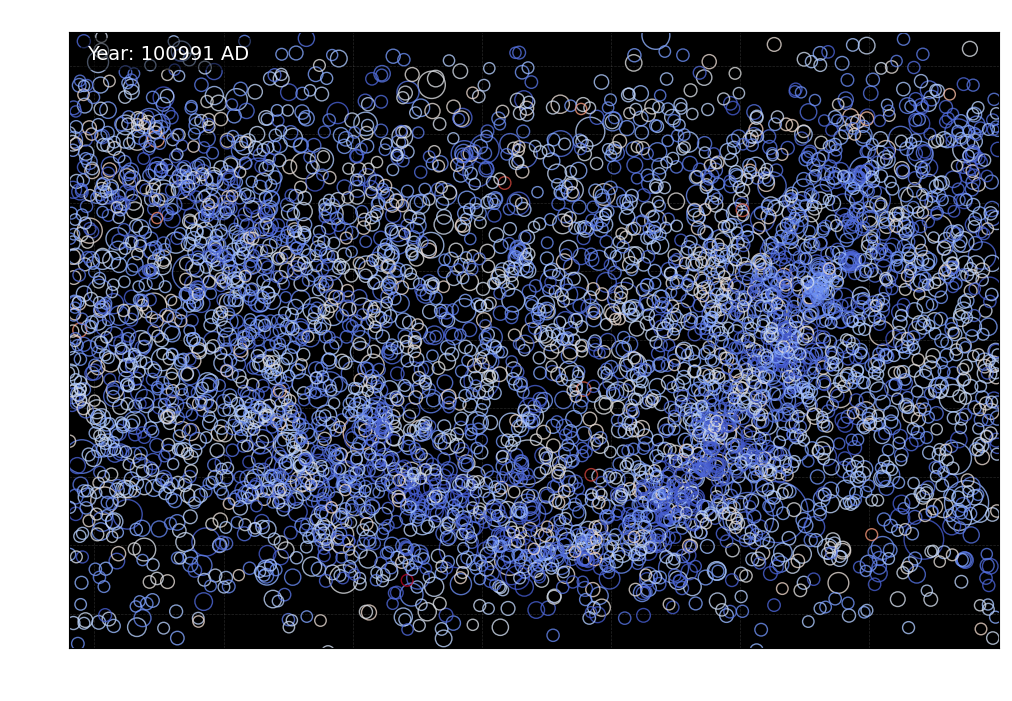

In [17]:
# --- Animation Setup (Original dynamic visualization, evolved over time) ---
# Normalize B-V for color mapping
norm = Normalize(vmin=df['B-V'].min(), vmax=df['B-V'].max())
cmap = plt.cm.coolwarm  # Changed from colormaps to plt.cm

# Precompute colors
colors = [cmap(norm(bv)) for bv in df['B-V']]

# Sizes based on magnitude
sizes = 100 * (10 ** ((5 - df['Vmag']) / 5))

# Figure setup
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('black')
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel('Right Ascension (degrees)', color='white')
ax.set_ylabel('Declination (degrees)', color='white')
ax.set_title('Evolution of Stars: Proper Motion Over Millennia', color='white')
ax.tick_params(colors='white')
ax.invert_xaxis()
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Initial scatter
scat = ax.scatter([], [], s=[], c=[], alpha=0.8, edgecolors='none')

# Time text
time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, color='white', fontsize=14,
                    verticalalignment='top', bbox=dict(facecolor='black', alpha=0.5))

def init():
    scat.set_offsets(np.empty((0, 2)))
    time_text.set_text('')
    return scat, time_text

def animate(year):
    T = year - 1991.25
    mas_to_deg = 1 / (3600 * 1000)

    delta_dec = df['pmDE'] * T * mas_to_deg
    new_dec = df['DEdeg'] + delta_dec

    dec_rad = np.deg2rad(df['DEdeg'])
    cos_dec = np.cos(dec_rad)
    cos_dec = np.clip(cos_dec, 1e-6, None)
    delta_ra = (df['pmRA'] / cos_dec) * T * mas_to_deg
    new_ra = (df['RAdeg'] + delta_ra) % 360

    positions = np.c_[new_ra, new_dec]
    scat.set_offsets(positions)
    scat.set_color(colors)
    scat.set_sizes(sizes)

    time_text.set_text(f'Year: {int(year)} AD')
    return scat, time_text

# Frames
years = np.arange(1991, 1991 + 100000, 1000)

# Animation
anim = FuncAnimation(fig, animate, frames=years, init_func=init, blit=True, interval=50)

# Save animation (with fallback)
try:
    anim.save('stellar_evolution_animation.mp4', writer='ffmpeg', fps=20, dpi=150)
    print("Animation saved as 'stellar_evolution_animation.mp4'.")
except ValueError:
    print("FFmpeg not found. Saving as GIF instead.")
    anim.save('stellar_evolution_animation.gif', writer='pillow', fps=20, dpi=150)
    print("Animation saved as 'stellar_evolution_animation.gif'.")

# List created files (cleanup summary like in notebook)
created_files = ['hipparcos_static_viz.svg', 'stellar_evolution_animation.mp4', 'stellar_evolution_animation.gif']
existing_files = [f for f in created_files if os.path.exists(f)]
print(f"Files created: {existing_files}")

In [28]:
# --- 3D Interactive Visualization with Plotly ---
import plotly.graph_objects as go
import plotly.express as px

# Ensure we have valid distance data
df_3d = df.dropna(subset=['Distance_pc']).copy()
# Limit to brightest 20 stars for performance in 3D
df_3d = df_3d.sort_values('Vmag').head(20)

# Convert spherical (RA, Dec, Distance) to cartesian (x, y, z)
def spherical_to_cartesian(ra_deg, dec_deg, dist_pc):
    ra_rad = np.deg2rad(ra_deg)
    dec_rad = np.deg2rad(dec_deg)
    x = dist_pc * np.cos(dec_rad) * np.cos(ra_rad)
    y = dist_pc * np.cos(dec_rad) * np.sin(ra_rad)
    z = dist_pc * np.sin(dec_rad)
    return x, y, z

# Compute 3D positions
x, y, z = spherical_to_cartesian(df_3d['RAdeg'], df_3d['DEdeg'], df_3d['Distance_pc'])

# Create star size and color mapping
marker_sizes = 5 * (10 ** ((5 - df_3d['Vmag']) / 5))  # Adjust size scaling

# Create interactive 3D scatter plot
fig = go.Figure()

# Add Earth at the center (0, 0, 0)
fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(
        size=10,
        color='green',
        symbol='circle'
    ),
    name='Earth',
    text=['Earth (0, 0, 0)'],
    hoverinfo='text'
))

# Add star scatter
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=marker_sizes,
        color=df_3d['B-V'],
        colorscale='RdBu_r',  # Reversed colorscale: blue (small values) to red (large values)
        colorbar=dict(title='B-V Color Index'),
        opacity=0.8
    ),
    text=[f'Vmag: {v:.1f}<br>Distance: {d:.1f} pc<br>B-V: {bv:.2f}' 
          for v, d, bv in zip(df_3d['Vmag'], df_3d['Distance_pc'], df_3d['B-V'])],
    hoverinfo='text'
))

# Add a semi-transparent sphere to represent the celestial sphere (using mesh3d to create the sphere)
max_dist = df_3d['Distance_pc'].max() * 1.1
phi = np.linspace(0, 2*np.pi, 50)
theta = np.linspace(-np.pi/2, np.pi/2, 25)
phi, theta = np.meshgrid(phi, theta)

x_sphere = max_dist * np.cos(theta) * np.cos(phi)
y_sphere = max_dist * np.cos(theta) * np.sin(phi)
z_sphere = max_dist * np.sin(theta)

fig.add_trace(go.Mesh3d(
    x=x_sphere.flatten(),
    y=y_sphere.flatten(),
    z=z_sphere.flatten(),
    alphahull=0,
    opacity=0.1,
    color='gray'
))

# update layout
fig.update_layout(
    title='Interactive 3D Celestial Sphere: Hipparcos Stars',
    scene=dict(
        xaxis_title='X (pc)',
        yaxis_title='Y (pc)',
        zaxis_title='Z (pc)',
        bgcolor='black',
        xaxis=dict(gridcolor='gray', gridwidth=1),
        yaxis=dict(gridcolor='gray', gridwidth=1),
        zaxis=dict(gridcolor='gray', gridwidth=1)
    ),
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    showlegend=False
)

# saved as HTML
fig.write_html('hipparcos_3d_interactive.html')

# Show plot
fig.show()

# 3D Interactive Animation with Plotly
Below is an interactive 3D animation showing the motion of the 20 brightest stars over 10,000 years. The animation includes:
- Play/Pause controls
- Time slider
- Interactive 3D controls (rotation, zoom, pan)
- Hover information for each star
- Color-coded stars based on B-V index (blue for smaller values, red for larger values)

In [30]:
# --- 3D Interactive Animation with Plotly ---
import plotly.graph_objects as go
import plotly.express as px

# Ensure we have valid distance data and proper motion
df_3d = df.dropna(subset=['Distance_pc', 'pmRA', 'pmDE']).copy()

# Calculate total proper motion magnitude (in mas/year)
df_3d['pm_total'] = np.sqrt(df_3d['pmRA']**2 + df_3d['pmDE']**2)

# Limit to 20 stars with the largest proper motion
df_3d = df_3d.sort_values('pm_total', ascending=False).head(20)
print("Selected stars proper motion range:", 
      f"Min: {df_3d['pm_total'].min():.1f} mas/year, Max: {df_3d['pm_total'].max():.1f} mas/year")

# Convert spherical (RA, Dec, Distance) to cartesian (x, y, z)
def spherical_to_cartesian(ra_deg, dec_deg, dist_pc):
    ra_rad = np.deg2rad(ra_deg)
    dec_rad = np.deg2rad(dec_deg)
    x = dist_pc * np.cos(dec_rad) * np.cos(ra_rad)
    y = dist_pc * np.cos(dec_rad) * np.sin(ra_rad)
    z = dist_pc * np.sin(dec_rad)
    return x, y, z

# Create frames for animation
years = np.arange(1991, 1991 + 10000, 100)  # 100年间隔，总共10000年
mas_to_deg = 1 / (3600 * 1000)

# Create frames for each year
frames = []
for i, year in enumerate(years):
    # Calculate new positions for this year
    T = year - 1991.25
    
    # Calculate new positions
    delta_dec = df_3d['pmDE'] * T * mas_to_deg
    new_dec = df_3d['DEdeg'] + delta_dec

    dec_rad = np.deg2rad(df_3d['DEdeg'])
    cos_dec = np.cos(dec_rad)
    cos_dec = np.clip(cos_dec, 1e-6, None)
    delta_ra = (df_3d['pmRA'] / cos_dec) * T * mas_to_deg
    new_ra = (df_3d['RAdeg'] + delta_ra) % 360

    # Convert new positions to cartesian coordinates
    x, y, z = spherical_to_cartesian(new_ra, new_dec, df_3d['Distance_pc'])
    
    # Create frame
    frame = go.Frame(
        data=[
            # Earth (static)
            go.Scatter3d(
                x=[0], y=[0], z=[0],
                mode='markers',
                marker=dict(size=10, color='green', symbol='circle'),
                name='Earth',
                text=['Earth (0, 0, 0)'],
                hoverinfo='text'
            ),
            # Stars (moving)
            go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(
                    size=5 * (10 ** ((5 - df_3d['Vmag']) / 5)),
                    color=df_3d['B-V'],
                    colorscale='RdBu_r',
                    colorbar=dict(title='B-V Color Index'),
                    opacity=0.8
                ),
                text=[f'Vmag: {v:.1f}<br>Distance: {d:.1f} pc<br>B-V: {bv:.2f}<br>Year: {year}' 
                      for v, d, bv in zip(df_3d['Vmag'], df_3d['Distance_pc'], df_3d['B-V'])],
                hoverinfo='text'
            )
        ],
        name=str(year)  # name the frame for slider
    )
    frames.append(frame)

# Create the initial figure with the first frame's data
fig = go.Figure(
    data=frames[0].data,
    frames=frames
)

# Add a semi-transparent sphere to represent the celestial sphere
max_dist = df_3d['Distance_pc'].max() * 1.1
phi = np.linspace(0, 2*np.pi, 50)
theta = np.linspace(-np.pi/2, np.pi/2, 25)
phi, theta = np.meshgrid(phi, theta)

x_sphere = max_dist * np.cos(theta) * np.cos(phi)
y_sphere = max_dist * np.cos(theta) * np.sin(phi)
z_sphere = max_dist * np.sin(theta)

fig.add_trace(go.Mesh3d(
    x=x_sphere.flatten(),
    y=y_sphere.flatten(),
    z=z_sphere.flatten(),
    alphahull=0,
    opacity=0.1,
    color='gray'
))

# Update layout with animation controls
fig.update_layout(
    title='Interactive 3D Celestial Sphere: Hipparcos Stars Motion',
    scene=dict(
        xaxis_title='X (pc)',
        yaxis_title='Y (pc)',
        zaxis_title='Z (pc)',
        bgcolor='black',
        xaxis=dict(gridcolor='gray', gridwidth=1),
        yaxis=dict(gridcolor='gray', gridwidth=1),
        zaxis=dict(gridcolor='gray', gridwidth=1)
    ),
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    showlegend=False,
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [
            {
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': 100, 'redraw': True},
                    'fromcurrent': True,
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            },
            {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': False},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }
        ]
    }],
    # Add slider
    sliders=[{
        'currentvalue': {'prefix': 'Year: ', 'visible': True},
        'pad': {'t': 50},
        'steps': [
            {
                'args': [[str(year)], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }],
                'label': str(year),
                'method': 'animate'
            } for year in years
        ]
    }]
)

# saved as HTML
fig.write_html('hipparcos_3d_interactive_animation.html')

# Show plot
fig.show()

Selected stars proper motion range: Min: 1583.9 mas/year, Max: 5280.7 mas/year
